In [1]:
!pip install --upgrade --quiet gspread
!pip install nltk

In [2]:
#Import necessary libraries

import pandas as pd
import numpy as np
import urllib.request
import json
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import linregress
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import re
import requests
import nltk
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentVader
nltk.download('vader_lexicon')
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
#Helper Functions and data

def get_trump_tweets():
  # This function grabs the Trump tweets from the CTASS GitHub
  return pd.read_json('https://raw.githubusercontent.com/ctass/fall-workshop-2019/master/trump_tweets.json')

party_name_dict = pd.read_json('https://raw.githubusercontent.com/ctass/fall-workshop-2019/master/moc_handle_dict.json')

def get_cong_tweet(date):
  #This function takes a date such as '2018-12-25' as a parameter and outputs
  #the tweets of all of the members of congress' tweets on that day. We combine
  #this data with a simple dictionary that contains MoCs' twitter handles,
  #names, and party affiliation.
  url = 'https://raw.githubusercontent.com/alexlitel/congresstweets/master/data/{}.json'.format(date)
  tweets = pd.read_json(url)
  global party_name_dict
  return tweets.merge(party_name_dict, on='screen_name')

def get_mfd():
  #This function grabs a version of the moral foundations dictionary from the
  #CTASS GitHub which can be used with the dict_vec function below
  return requests.get('https://raw.githubusercontent.com/ctass/fall-workshop-2019/master/mfd.dict').json()

def get_news(source, date):
    #This function grabs the front page of MSNBC or Fox News on a particular day
    #returns it as a single string. These were sourced from the Internet Archive 
    #and stored on the CTASS Github. The function takes a source (either 'msnbc'
    #or 'fox') and dates of the form YYYY-MM-DD. News has been 
    #archived from '2019-10-21' to '2019-11-21' (inclusive), except that for a
    #couple of days we had to grab a post near midnight the next day.
    base = 'https://raw.githubusercontent.com/ctass/fall-workshop-2019/master/news/'
    url = base + source + '-' + date.replace('-', '') + '.txt'
    data = urllib.request.urlopen(url)
    return data.read().decode('utf-8').replace('\n', ' ')
    
def regexify(s):
  #Helper function for dictify below
  if s[-1] == "*":
    return r'(?<!\w){}\w*?[\s.]'.format(s[:-1])
  return r'(?<!\w){}[\s.]'.format(s)

def dictify(d):
  #Takes in a dictionary where keys are categories and the values are lists of
  #words that indicate each category. Outputs a dictionary that can be used by
  #dict_vec below. Helpful if you are not comfortable with regular expressions,
  #but is limited by design. There is one key functionality built in: if a word
  #ends in a "*", then the generated regular expression will look for words with
  #any additional letters at the end of it (e.g. "eat*" captures "eat", 
  #"eating", "eats", etc.). The same does not hold for "*" at the beginning of a 
  #word.
  return {k: [regexify(w) for w in d[k]] for k in d}

def dict_vec(s, d):
  #Takes in a string and a dictionary which is structured {C1: [W11, W21, ...],
  #                                                        C2: [W12, W22, ...]}
  #Where Cx is the name of a category and Wxy is a regular expression which
  #indicates a string 'more belongs' in category x and outputs a dictionary
  #structured {C1: S1, C2: S2, ...} where Cx is the name of a category and
  #Sx is how much the passed string 'belongs' in that category.
  results = {k: 0 for k in d.keys()}
  results['_total_'] = 0
  s = s.lower().translate(str.maketrans('', '', string.punctuation))
  for k in d.keys():
    for t in d[k]:
      count = len(re.findall(t,s.lower()+' '))
      results[k] += count
      results['_total_'] += count
  results['_len_'] = len(nltk.tokenize.word_tokenize(s))
  return results


#**Accessing Three Available Corpora**

For the purposes of this workshop we've made starter code that allows you to easily access three different text corpora: (1) DJT's tweets, (2) Tweets of every member of the US congress, and (3) the front pages of MSNBC.com and FoxNews.com. We've attempted to make the starter code as straight-forward as possible, and below provide code that you can copy and paste for many analyses. **DISCLAIMER:** all of the corpora come from second-hand sources. Therefore, we cannot speak to the accuracy of these data, though from some intial snooping around the data seems to check out.

##Donald Trump's Tweets since the Inauguration
We have a little helper function that allows you to download DJT's tweets from
the CTASS GitHub. It will automatically output it as a Pandas DataFrame,
which is a useful tool for doing data science in Python. See below for an
example of loading the tweets and assigning it to a variable df. We also
remove retweets (you don't have to) and drop the id_str variable

In [4]:
df = get_trump_tweets()
df = df[df['is_retweet']==0.0].drop(['is_retweet','id_str'],axis=1)
df

,source,text,created_at,retweet_count,favorite_count
0,Twitter for iPhone,Nancy Pelosi just stated that “it is dangerous...,2019-11-19 05:15:15+00:00,37930,125494
1,Twitter for iPhone,The Do Nothing Democrats have disgraced our gr...,2019-11-19 03:41:50+00:00,17657,59112
4,Twitter for iPhone,"At my meeting with Jay Powell this morning, I ...",2019-11-19 03:34:12+00:00,17343,69909
5,Twitter for iPhone,Mark Levin speaking one week after I took offi...,2019-11-18 23:54:32+00:00,24456,75362
6,Twitter for iPhone,GREAT NEWS! #MAGA #KAG https://t.co/GXDE2IlGGu,2019-11-18 21:28:30+00:00,15694,58500
...,...,...,...,...,...
12436,Twitter for iPhone,"January 20th 2017, will be remembered as the d...",2017-01-20 17:53:17+00:00,60604,218555
12437,Twitter for iPhone,What truly matters is not which party controls...,2017-01-20 17:52:45+00:00,42790,180394
12438,Twitter for iPhone,"power from Washington, D.C. and giving it back...",2017-01-20 17:51:58+00:00,18362,91143
12439,Twitter for iPhone,Today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,20125,109640


##Tweets from Members of Congress (MoCs)
Next we have a function that takes in a date (e.g. '2017-11-17') and spits back
all the tweets sent out by any member of congress on that day. Importantly,
this data is maintained by the GitHub user alexlitel, so our ability to access
this data is all due to them. Thank you whoever you are! Importantly, we don't
have access to the number of favorites or retweets of these tweets. Also, we only have access to tweets starting on June 21st of 2017. The function then also matches these Twitter handles to the MoC's name and their party affiliation, which combines data maintained by triagecancer.org, opendatasoft.com, and opensecrety.org. We'll drop some columns that don't on their face appear to be helpful.

In [5]:
get_cong_tweet('2017-11-17').drop(['id','user_id'], axis=1)

,screen_name,time,link,text,source,name,party
0,SenatorShaheen,2017-11-17T14:26:45-05:00,https://www.twitter.com/SenatorShaheen/statuse...,The #GOPTaxBill again tries to repeal parts of...,Twitter Web Client,Jeanne Shaheen,Democrat
1,SenatorShaheen,2017-11-17T14:29:33-05:00,https://www.twitter.com/SenatorShaheen/statuse...,"Under #GOPTaxBill, homeowners in NH lose the a...",Twitter Web Client,Jeanne Shaheen,Democrat
2,SenatorShaheen,2017-11-17T15:24:15-05:00,https://www.twitter.com/SenatorShaheen/statuse...,My statement on the Senate Republican tax bill...,Twitter Web Client,Jeanne Shaheen,Democrat
3,SenatorShaheen,2017-11-17T14:25:11-05:00,https://www.twitter.com/SenatorShaheen/statuse...,"THREAD: We need to simplify our tax code, help...",Twitter Web Client,Jeanne Shaheen,Democrat
4,SenatorShaheen,2017-11-17T16:11:58-05:00,https://www.twitter.com/SenatorShaheen/statuse...,New evidence from @hrw that Rohingya women &am...,Twitter Web Client,Jeanne Shaheen,Democrat
...,...,...,...,...,...,...,...
904,RepMarkTakano,2017-11-17T14:52:17-05:00,https://www.twitter.com/RepMarkTakano/statuses...,The Trump administration has been holding secr...,Twitter Web Client,Mark Takano,Democrat
905,RepGraceMeng,2017-11-17T12:33:43-05:00,https://www.twitter.com/RepGraceMeng/statuses/...,Met on Capitol Hill with U.S. Transportation S...,Twitter Web Client,Grace Meng,Democrat
906,RepGraceMeng,2017-11-17T17:35:17-05:00,https://www.twitter.com/RepGraceMeng/statuses/...,A day after I sent a letter to @DHSgov Secreta...,Twitter Web Client,Grace Meng,Democrat
907,RepChrisCollins,2017-11-17T11:39:03-05:00,https://www.twitter.com/RepChrisCollins/status...,Visited the Genesee County Career Center in Ba...,Twitter for iPhone,Chris Collins,Republican


##The front pages of Foxnews.com and MSNBC.com

Lastly, we have a small corpus we've collected (with the help of the Wayback machine internet archive) of the front page of msnbc.com and foxnews.com. We've collected all of the text from the front of these websites from October 21st to November 21st, with the one caveat that for a couple of days (November 7th and November 10th) we couldn't grab the front page of MSNBC, so we instead use a grab from around midnight the next day. The function takes in the source (either 'msnbc' or 'fox') and the date (e.g. '2019-11-19' for November 11th of 2019) and returns back a string that isn't that pretty but contains all the relevant information. Since we're primarily exploring dictionary methods here this won't be too much of a problem, but you could imagine that if we wanted to use more complicated methods that leveraged the structure of language we might need to be a little more sophisticated with how we collect and clean this data. 

In [6]:
get_news('msnbc','2019-11-19')

'      MSNBC     Listen     Watch      Rachel MaddowMorning JoeDeadline: WHMTP DailyThe BeatAll InHardballLast Word11th Hour      Share this  —  Featured Shows      Morning Joe     Hardball     All In     Rachel Maddow     Last Word     11th Hour     Deadline WH     MTP Daily     The Beat     AM Joy  More      Listen Live     TV Schedule     Watch Live  More Shows      Morning Joe First Look     MSNBC Live with Stephanie Ruhle     MSNBC Live with Hallie Jackson     Velshi & Ruhle     Andrea Mitchell Reports     MSNBC Live with Katy Tur     MSNBC Live with Craig Melvin     MSNBC Live with Ali Velshi     MSNBC Live with Alex Witt     UP with David Gura     PoliticsNation     Kasie DC     MSNBC Documentaries  Follow msnbc      Print     Whatsapp     Reddit     Pocket     Flipboard     Pinterest     Linkedin  The Beat with Ari Revealed: Trump aide\'s leaked emails show alleged bribery plot Hardball Republicans struggle to defend Trump following impeachment hearings Must Watch SEE ALL 05:00

#**Example Analyses Using the Data**
Next, we do some basic data analysis and visualization. If you're not very comfortable doing analyses in Python, copying and pasting this code and changing a few variables here and there is a great way to get started. Regardless of your comfort level with Python, these are some fairly simple analyses that can get your creativity going to come up with your own analyses. There's plenty of different ways we could have done any of these analyses; we emphasized simplicity of code and analyses that are easy to follow.

##Basic Data Visualization and Analysis in Colab

We're going to use a library called Seaborn for visualization. There are many
other tools that are worth looking into, but Austin likes Seaborn because
it's pretty easy to use, especially if you're already familiar with matplot,
and makes reasonably pretty graphs (big step up from standard Stata graphs at least). This command just sets the style of our graphs. Austin likes this particular style, but you can also try 'darkgrid', 'dark', 'white', or 'ticks'

In [0]:
sb.set_style('whitegrid')

Here we'll produce a regression plot of the relationship between the
number of retweets a tweet has and the number of favorites it has.
We'll then do a regression using scipy to get a p-value (though we can see from
the bootstrapped confidence intervals in the plot that this is relationship
is highly significant). One thing that would definitely make this plot more
legible is setting bounds on the x and y axis to exclude outliers.

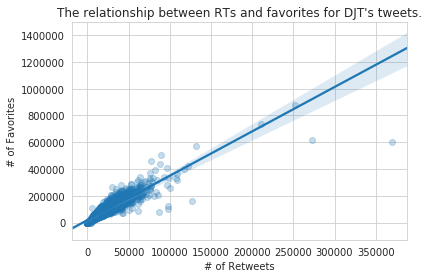

Does the number of favorites increase with the number of retweets?
LinregressResult(slope=3.3108408454974487, intercept=19137.283759589496, rvalue=0.9096119755381236, pvalue=0.0, stderr=0.01558310014821565)


In [8]:
plt.scatter(df['retweet_count'],df['favorite_count'], alpha=0.25)
#NOTE: "alpha" is a parameter that controls how transparent the scatterplot
#points are in the scatterplot
sb.regplot(df['retweet_count'],df['favorite_count'],scatter=False)
plt.xlabel('# of Retweets')
plt.ylabel('# of Favorites')
plt.title("The relationship between RTs and favorites for DJT's tweets.")
plt.show()
print('Does the number of favorites increase with the number of retweets?')
print(linregress(df['retweet_count'],df['favorite_count']))

Here we'll look at the mean number of retweets and favorites for tweets
from different sources. You can get a sense from the confidence intervals
which tweet sources are more common in the data. I would consider dropping
the Twitter Web Client category from this analysis.

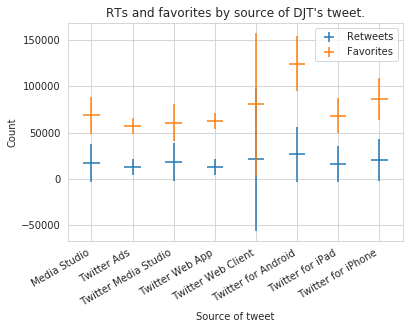

In [9]:
mean_retweets = df.groupby('source')['retweet_count'].mean()
std_retweets = df.groupby('source')['retweet_count'].std()

mean_favorites = df.groupby('source')['favorite_count'].mean()
std_favorites = df.groupby('source')['favorite_count'].std()

source_rt_name, source_rt_code = np.unique(mean_retweets.index, 
                                           return_inverse=True)
source_fv_name, source_fv_code = np.unique(mean_favorites.index, 
                                           return_inverse=True)

plt.errorbar(source_rt_code, mean_retweets, xerr=0.2, yerr=2*std_retweets, 
             linestyle='', label='Retweets')
plt.errorbar(source_rt_code, mean_favorites, xerr=0.2, yerr=2*std_retweets, 
             linestyle='', label='Favorites')

plt.xticks(source_rt_code, source_rt_name, rotation=30, ha='right')
plt.legend()
plt.title("RTs and favorites by source of DJT's tweet.")
plt.xlabel('Source of tweet')
plt.ylabel('Count')
plt.show()

Here we're going to test whether Trump's tweets received more favorites and
retweets on average in 2018 when compared to tweets in 2017. I excluded the
2019 tweets because it makes the graphs look busy, but the command to plot them
is simply commented out. Note that like many of our analyses here, our outcome is technically a count variable and should be analyzed by something that takes such a fact into account such as a negative binomial model, but also note from the histogram that it's incredibly unlikely that such a model would not return a significant association.

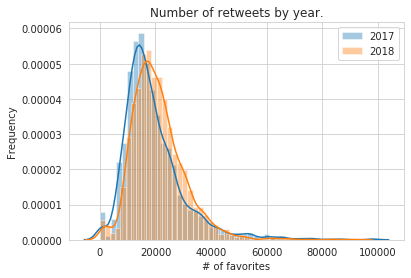

Is there a mean difference in the number of retweets for the years 2017 and 2018?
Ttest_indResult(statistic=-5.391132078607363, pvalue=7.390224222500319e-08)


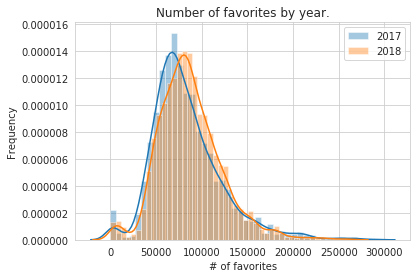

Is there a mean difference in the number of favorites for the years 2017 and 2018?
Ttest_indResult(statistic=-3.1392132962766452, pvalue=0.0017054134601806115)


In [10]:
rt = {2017: [],
      2018: [],
      2019: []}

fv = {2017: [],
      2018: [],
      2019: []}

for i, row in df.iterrows():
    yr = row['created_at'].year
    if row['retweet_count'] < 100000:
      rt[yr].append(row['retweet_count']) 
    if row['favorite_count'] < 300000:
      fv[yr].append(row['favorite_count'])

sb.distplot(rt[2017], label='2017')
sb.distplot(rt[2018], label='2018')
#sb.distplot(rt[2019], label='2019')

plt.legend()
plt.xlabel('# of favorites')
plt.ylabel('Frequency')
plt.title('Number of retweets by year.')

plt.show()

print("Is there a mean difference in the number of retweets for the years 2017 and 2018?")
print(ttest_ind(rt[2017],rt[2018],equal_var=False))

sb.distplot(fv[2017], label='2017')
sb.distplot(fv[2018], label='2018')
#sb.distplot(fv[2019], label='2019')

plt.legend()
plt.xlabel('# of favorites')
plt.ylabel('Frequency')
plt.title('Number of favorites by year.')

plt.show()

print("Is there a mean difference in the number of favorites for the years 2017 and 2018?")
print(ttest_ind(fv[2017],fv[2018],equal_var=False))

##Sentiment Analysis

This is a quick demo of how to use Vader, which is a sentiment analysis tool
developed by the NLTK group here at Stanford. It's basically a sentiment
lexicon, but uses some smart heuristics to do a slightly better job.
You can get degree to which a string is positive, neutral, or negative, or you
get a compound or summary score

In [11]:
sent = sentVader()

print(sent.polarity_scores('Everything about this is awesome. Except for the bagels, which are amazing'))
print(sent.polarity_scores('Everything about this is terrible. Except for the bagels, which are amazing'))
print(sent.polarity_scores('Everything about this is terrible. Except for the bagels, which are still not amazing'))

{'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'compound': 0.836}
{'neg': 0.183, 'neu': 0.592, 'pos': 0.225, 'compound': 0.1779}
{'neg': 0.34, 'neu': 0.66, 'pos': 0.0, 'compound': -0.7329}


What can we do with sentiment analysis? Let's see whether Democrats and
Republicans tweeted differently sentimented language this Wednesday, November 20th. 

In [0]:
df = get_cong_tweet('2019-11-20')

Then, we'll, create two lists; corresponding to the sentiments of tweets
tweeted by Democrats and Republicans, respectively

In [0]:
dems = []
pubs = []
sent = sentVader()

for i, row in df.iterrows():
  s = sent.polarity_scores(row['text'])['compound']
  if row['party'] == 'Democrat':
    dems.append(s)
  elif row['party'] == 'Republican':
    pubs.append(s)

Lastly, we'll produce a graph showing the histograms of sentiments by the two
parties and do a simple t-test to asses whether there is a statistically
significant difference

Ttest_indResult(statistic=-4.359993131050193, pvalue=1.3724235418691392e-05)


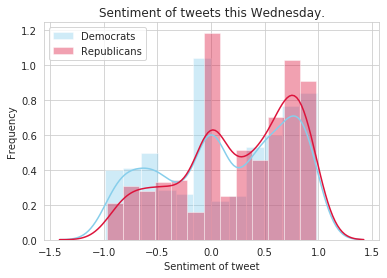

In [14]:
sb.distplot(dems, label='Democrats', color='skyblue')
sb.distplot(pubs, label='Republicans', color='crimson')

plt.legend()
plt.xlabel('Sentiment of tweet')
plt.ylabel('Frequency')
plt.title('Sentiment of tweets this Wednesday.')

print(ttest_ind(dems, pubs, equal_var=False))

Just as a cautionary note: often with computational methods you'll get crazy distributions like this, which don't necessarily meet the assumptions of different statistical tests such as a t-test, making your p-values invalid. It's nice to have a good understanding of statistics so that you know when you're breaking these rules, and how you can do analyses that don't make such assumptions. For instance, here (and in many other analyses we do here) you could do a Fischer randomization test, and specifically here the test statistic could be the mean of the sentiment score. The Fischer randomization test is model-free and doesn't make any assumption about the marginal distributions of the outcome variable.

##(Other) Dictionary Methods

Now we've got a series of functions to help you do other dictionary-
based analyses. First up is this get_mfd function, which downloads a Python-
friendly version of the Moral Foundations Dictionary from the CTASS GitHub.
The dictionary isn't made up words per se, but instead regular expressions,
which allow for efficient searching of resonably complicated patterns in text.
There are other ways we could have coded this, but we preferred this for its
flexibility and its scalability (in terms of the length of analyzed texts).

In [15]:
mfd = get_mfd()
mfd

{'AuthorityVice': ['(?<!\\w)betray\\w*?[\\s.]',
  '(?<!\\w)treason\\w*?[\\s.]',
  '(?<!\\w)traitor\\w*?[\\s.]',
  '(?<!\\w)treacher\\w*?[\\s.]',
  '(?<!\\w)disloyal\\w*?[\\s.]',
  '(?<!\\w)apostasy[\\s.]',
  '(?<!\\w)apostate[\\s.]',
  '(?<!\\w)deserted[\\s.]',
  '(?<!\\w)deserter\\w*?[\\s.]',
  '(?<!\\w)deserting[\\s.]',
  '(?<!\\w)defian\\w*?[\\s.]',
  '(?<!\\w)rebel\\w*?[\\s.]',
  '(?<!\\w)dissent\\w*?[\\s.]',
  '(?<!\\w)subver\\w*?[\\s.]',
  '(?<!\\w)disrespect\\w*?[\\s.]',
  '(?<!\\w)disobe\\w*?[\\s.]',
  '(?<!\\w)sediti\\w*?[\\s.]',
  '(?<!\\w)agitat\\w*?[\\s.]',
  '(?<!\\w)insubordinat\\w*?[\\s.]',
  '(?<!\\w)illegal\\w*?[\\s.]',
  '(?<!\\w)lawless\\w*?[\\s.]',
  '(?<!\\w)insurgent[\\s.]',
  '(?<!\\w)mutinous[\\s.]',
  '(?<!\\w)defy\\w*?[\\s.]',
  '(?<!\\w)dissident[\\s.]',
  '(?<!\\w)unfaithful[\\s.]',
  '(?<!\\w)alienate[\\s.]',
  '(?<!\\w)defector[\\s.]',
  '(?<!\\w)heretic\\w*?[\\s.]',
  '(?<!\\w)nonconformist[\\s.]',
  '(?<!\\w)oppose[\\s.]',
  '(?<!\\w)protest[\\s.]',
  '(

The next function takes in any such dictionary (you can make your own! See 
below) and outputs a dictionary indicating a string's score on each of the
dictionary's categories. It also creates a \_total\_ category (the sum of all the other categories) as well as a \_len\_ category (the number of words in the string), in case you want to normalize the scores of the other categories.

In [16]:
dict_vec('This is an unjust test string. It is a very pure test string.',mfd)

{'AuthorityVice': 0,
 'AuthorityVirtue': 0,
 'FairnessVice': 1,
 'FairnessVirtue': 0,
 'HarmVice': 0,
 'HarmVirtue': 0,
 'IngroupVice': 0,
 'IngroupVirtue': 0,
 'MoralityGeneral': 0,
 'PurityVice': 0,
 'PurityVirtue': 1,
 '_len_': 13,
 '_total_': 2}

Here's a demo of defining your own dictionary for analysis. Though you can
certainly do this with one line of code, we'll break into steps so it's easier
to follow. First, define lists of words that relate to the different categories
in your dictionary. You can put a "*" at the end of a word to capture any word
that starts with those letters. For instance, "eat*" will capture "eat",
"eating", and "eats", where "eat" will only capture "eat".

In [0]:
politic_words = ['politi*', 'congress*', 'president*', 'democrat', 'republican']
food_words = ['tuna', 'pineapple', 'burger', 'din*', 'eat*']

Then define a dictionary in which the key is a name for each category in the
dictionary and the value are the appropriate lists you defined before


In [0]:
new_dict = {'politics': politic_words, 
            'food': food_words}

Then lastly pass that dictionary into our dictify function, which just turns
your words into regular expressions for you!

In [0]:
new_dict = dictify(new_dict)

Then you can use your dictionary just like how we used the MF dictionary!

In [20]:
dict_vec('These congressional hearings are eating him alive', new_dict)

{'_len_': 7, '_total_': 2, 'food': 1, 'politics': 1}

So what can we do with these dictionary methods? Moral foundations theory
posits that conservatives care more about a subset of moral dimensions (namely
purity, authority, and ingroup) than liberals. Something that would be
consistent with such a theory would be if FoxNews.com (which has a more
conservative viewership) used more language that appealed to such moral
foundations than MSNBC.com (which has a more liberal viewership). So, we'll
simply compare the text on the front pages of these two websites and see the
degree to which these two websites use words from those sections of the moral
foundations dictionary more.
We'll iterate over each day of data that we have. For each day, we'll load the
text from the front pages of the two websites. For each website, we'll get the
count of words in the vice and virtue categories associatied with ingroup,
authority, and purity, and add that number normalized by the number of words on the front page to lists we maintain.

In [0]:
msnbc_pur = []
msnbc_auth = []
msnbc_ingrp = []

fox_pur = []
fox_auth = []
fox_ingrp = []

for date in ['2019-10-21','2019-10-22','2019-10-23','2019-10-24','2019-10-25',
             '2019-10-26','2019-10-27','2019-10-28','2019-10-29','2019-10-30',
             '2019-10-31',
             '2019-11-01','2019-11-02','2019-11-03','2019-11-04','2019-11-05',
             '2019-11-06','2019-11-07','2019-11-08','2019-11-09','2019-11-10',
             '2019-11-11','2019-11-12','2019-11-13','2019-11-14','2019-11-15',
             '2019-11-16','2019-11-17','2019-11-18','2019-11-19','2019-11-20',
             '2019-11-21']:

  msnbc = get_news('msnbc',date)
  msnbc_vec = dict_vec(msnbc, mfd)
  m_len = msnbc_vec['_len_']

  fox = get_news('fox',date)
  fox_vec = dict_vec(fox, mfd)
  f_len = fox_vec['_len_']

  msnbc_pur.append((msnbc_vec['PurityVirtue'] + msnbc_vec['PurityVice'])/m_len)
  msnbc_auth.append((msnbc_vec['AuthorityVirtue'] + msnbc_vec['AuthorityVice'])/m_len)
  msnbc_ingrp.append((msnbc_vec['IngroupVirtue'] + msnbc_vec['IngroupVice'])/m_len)

  fox_pur.append((fox_vec['PurityVirtue'] + fox_vec['PurityVice'])/f_len)
  fox_auth.append((fox_vec['AuthorityVirtue'] + fox_vec['AuthorityVice'])/f_len)
  fox_ingrp.append((fox_vec['IngroupVirtue'] + fox_vec['IngroupVice'])/f_len)

Now, we're going to make a weird assumption and use a paired sample t-test, with the idea that we're analyzing whether the objective day of events is describesd differently by
Fox and MSNBC, which we're conceptualizing as the condition. We're further going
to treat what is obviously a fractional variable as a continuous variable, just
for sake of implementation and such. Definitely different (slash better) ways 
one could do this analysis!

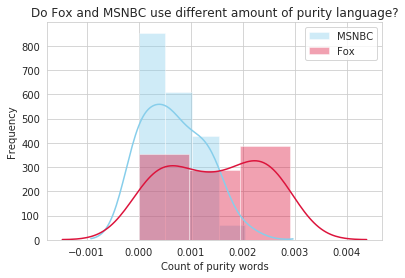

Ttest_relResult(statistic=-4.348403232654401, pvalue=0.00013753130110785868)


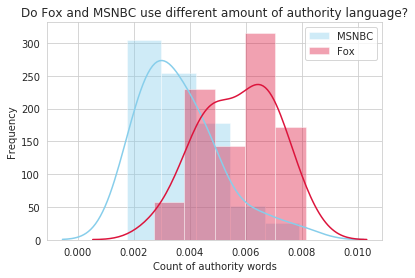

Ttest_relResult(statistic=-6.284475231857822, pvalue=5.475762343426768e-07)


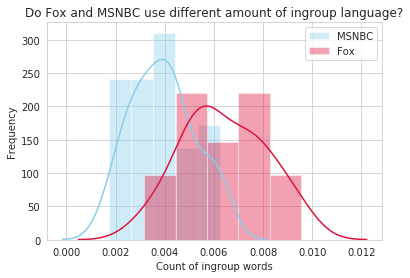

Ttest_relResult(statistic=-7.125462025343426, pvalue=5.2390244379255144e-08)


In [23]:
sb.distplot(msnbc_pur, label='MSNBC', color='skyblue')
sb.distplot(fox_pur, label='Fox', color='crimson')
plt.legend()
plt.xlabel('Count of purity words')
plt.ylabel('Frequency')
plt.title('Do Fox and MSNBC use different amount of purity language?')
plt.show()
print(ttest_rel(msnbc_pur, fox_pur))

sb.distplot(msnbc_auth, label='MSNBC', color='skyblue')
sb.distplot(fox_auth, label='Fox', color='crimson')
plt.legend()
plt.xlabel('Count of authority words')
plt.ylabel('Frequency')
plt.title('Do Fox and MSNBC use different amount of authority language?')
plt.show()
print(ttest_rel(msnbc_auth, fox_auth))

sb.distplot(msnbc_ingrp, label='MSNBC', color='skyblue')
sb.distplot(fox_ingrp, label='Fox', color='crimson')
plt.legend()
plt.xlabel('Count of ingroup words')
plt.ylabel('Frequency')
plt.title('Do Fox and MSNBC use different amount of ingroup language?')
plt.show()
print(ttest_rel(msnbc_ingrp, fox_ingrp))

#**Your turn!**